In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis_sol
import matplotlib.pyplot as plt
import cupy as cp
importlib.reload(kgs)
#pack_vis.plot_polygons([kgs.center_tree] + kgs.convex_breakdown)

local
local


<module 'kaggle_support' from '/mnt/d/packing/code/analysis/../core/kaggle_support.py'>

In [2]:
dat = kgs.dill_load(kgs.code_dir + '/../res/mine.pickle')

<Axes: >

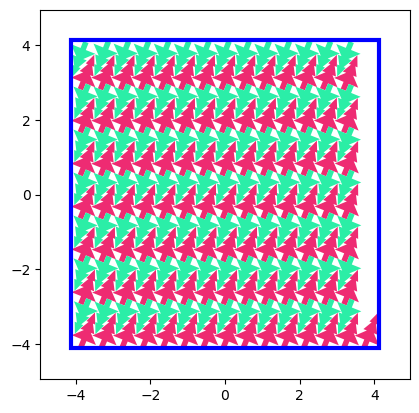

In [13]:
pack_vis_sol.pack_vis_sol(dat[0][196])